# VILAISOUK KHOUNMY
# 227480201IS004


# Phân tích điểm thi và ứng dụng CNN


## Phần A: Bộ dữ liệu điểm thi sinh viên
### Dưới đây là bộ dữ liệu giả định về điểm thi của 30 sinh viên, bao gồm các cột: Student_ID, Course,Score (0-100), Attendance (%) (0-100)Study_Hours, Gender, Campus. Một số giá trị bị thiếu để bạnthực hành xử lý.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

# Create the student data
data = {
    'Student_ID': ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010',
                  'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020',
                  'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030'],
    'Course': ['Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 
              'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math',
              'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry',
              'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry'],
    'Score': [85, np.nan, 78, 92, 65, 88, 80, 75, 90, 70, 82, 85, 95, 68, 83, 77, 89, 72, 84, 91, 
             66, 87, 75, 93, 79, 86, 71, 94, 80, 88],
    'Attendance (%)': [90, 85, np.nan, 95, 60, np.nan, np.nan, 88, 92, 65, 75, 85, 98, np.nan, 90, 
                     70, 95, 80, np.nan, 88, 60, 92, np.nan, 97, 85, 90, np.nan, 95, 70, 88],
    'Study_Hours': [5, 4, np.nan, 6, 3, 5, 4, 5, np.nan, 3, 4, 6, 7, 3, 5, 4, np.nan, 3, 5, 6, 
                   2, 5, 4, np.nan, 3, 5, 4, 6, 3, 5],
    'Gender': ['Male', 'Female', 'Male', 'Female', np.nan, 'Male', 'Female', 'Male', 'Female', 
              'Male', 'Female', 'Male', 'Female', 'Male', np.nan, 'Female', 'Male', 'Female', 
              'Male', 'Female', np.nan, 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 
              np.nan, 'Male', 'Female'],
    'Campus': ['Campus_A', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 
              'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 
              'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 
              'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 
              'Campus_B', 'Campus_A']
}

df = pd.DataFrame(data)
print(df.head())

  Student_ID     Course  Score  Attendance (%)  Study_Hours  Gender    Campus
0       S001       Math   85.0            90.0          5.0    Male  Campus_A
1       S002    Physics    NaN            85.0          4.0  Female  Campus_B
2       S003  Chemistry   78.0             NaN          NaN    Male  Campus_A
3       S004       Math   92.0            95.0          6.0  Female  Campus_C
4       S005    Physics   65.0            60.0          3.0     NaN  Campus_B


## Phần B: Câu hỏi kiểm tra

In [4]:
# 1. (4 điểm) Tính tỷ lệ phần trăm giá trị thiếu trong từng cột bằng Pandas. Dựa trên kết quả, đề xuất
# một quy trình thu thập dữ liệu cụ thể cho trường học để giảm thiểu dữ liệu thiếu trong tương lai,
# giải thích tại sao quy trình này phù hợp với từng môn học (Math, Physics, Chemistry).


missing_percentages = df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
Student_ID         0.000000
Course             0.000000
Score              3.333333
Attendance (%)    23.333333
Study_Hours       13.333333
Gender            13.333333
Campus             0.000000
dtype: float64



Điểm trung bình theo môn học (Course):
Course
Chemistry    81.4
Math         84.3
Physics      79.0
Name: Score, dtype: float64


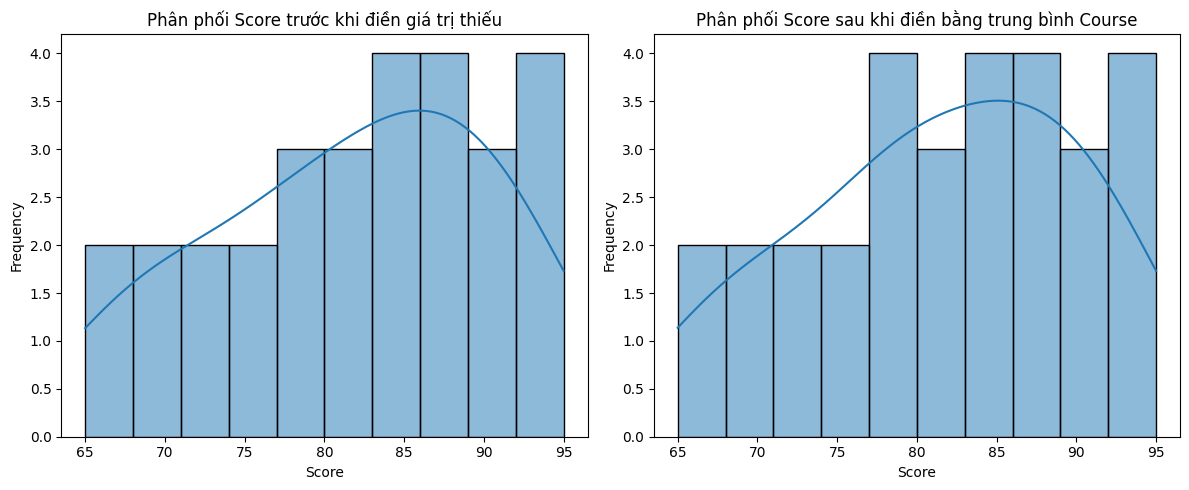

In [11]:
# 2. (4 điểm) Điền giá trị thiếu trong Score bằng trung bình của Course tương ứng, sau đó đề xuất
# một phương pháp điền giá trị khác (không dùng thư viện tự động) dựa trên đặc điểm của từng
# Campus. Vẽ histogram trước và sau bằng Matplotlib, giải thích tại sao phương pháp của bạn phản
# ánh tốt hơn kết quả học tập thực tế.


df_original = df.copy()

# Tính giá trị trung bình của Score theo Course
course_mean_scores = df.groupby('Course')['Score'].mean()
print("\nĐiểm trung bình theo môn học (Course):")
print(course_mean_scores)

# Điền giá trị thiếu trong Score bằng trung bình của Course tương ứng
df_course_mean = df.copy()
for course in df['Course'].unique():
    mean_score = course_mean_scores[course]
    df_course_mean.loc[(df_course_mean['Course'] == course) & (df_course_mean['Score'].isnull()), 'Score'] = mean_score

# Vẽ histogram Score trước và sau khi điền giá trị thiếu
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_original['Score'], kde=True, bins=10)
plt.title('Phân phối Score trước khi điền giá trị thiếu')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_course_mean['Score'], kde=True, bins=10)
plt.title('Phân phối Score sau khi điền bằng trung bình Course')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [21]:
# 3. (4 điểm) Tính độ lệch chuẩn của Study_Hours bằng NumPy. Đề xuất một chính sách khuyến khích
# học tập cho sinh viên dựa trên phân tích độ lệch chuẩn và trung vị, giải thích tại sao chính sách
# này có thể cải thiện điểm số tổng thể.
# Fill missing values in Study_Hours for the calculation
study_hours_filled = df['Study_Hours'].fillna(df['Study_Hours'].median())

# Calculate standard deviation and median of Study_Hours
std_study_hours = np.std(study_hours_filled)
median_study_hours = np.median(study_hours_filled)

print("Standard Deviation of Study_Hours: ", std_study_hours)
print("Median of Study_Hours: ",median_study_hours)



Standard Deviation of Study_Hours:  1.1308796969124912
Median of Study_Hours:  4.5


Tương quan giữa điểm danh và điểm số theo Campus:
Campus
Campus_A    0.820944
Campus_B    0.592624
Campus_C    0.941335
Name: Score, dtype: float64


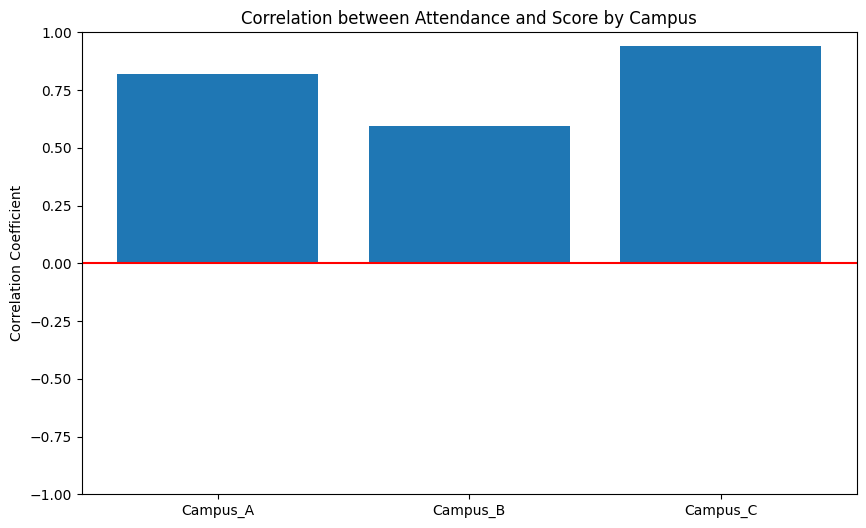

In [42]:
# 4. (4 điểm) Tính correlation giữa Attendance (%) và Score cho từng Campus. Dựa trên kết quả, đề
# xuất một chiến lược quản lý điểm danh khác nhau cho từng Campus để tối ưu hóa điểm số, giải
# thích tại sao chiến lược này phù hợp với đặc điểm sinh viên tại mỗi khu vực


# Tạo bản sao và điền giá trị thiếu tạm thời cho phân tích tương quan
df_temp = df.copy()
df_temp['Attendance (%)'] = df_temp['Attendance (%)'].fillna(df_temp['Attendance (%)'].mean())
df_temp['Score'] = df_temp['Score'].fillna(df_temp.groupby('Course')['Score'].transform('mean'))

# Tính tương quan giữa Attendance và Score cho từng Campus
campus_correlation = df_temp.groupby('Campus')[['Attendance (%)', 'Score']].corr().iloc[::2, 1]
campus_correlation.index = campus_correlation.index.droplevel(1)
print("Tương quan giữa điểm danh và điểm số theo Campus:")
print(campus_correlation)

# Visualize the correlation
plt.figure(figsize=(10, 6))
plt.bar(campus_correlation.index, campus_correlation.values)
plt.title('Correlation between Attendance and Score by Campus')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()




Outliers in Score column:
Empty DataFrame
Columns: [Student_ID, Course, Score]
Index: []


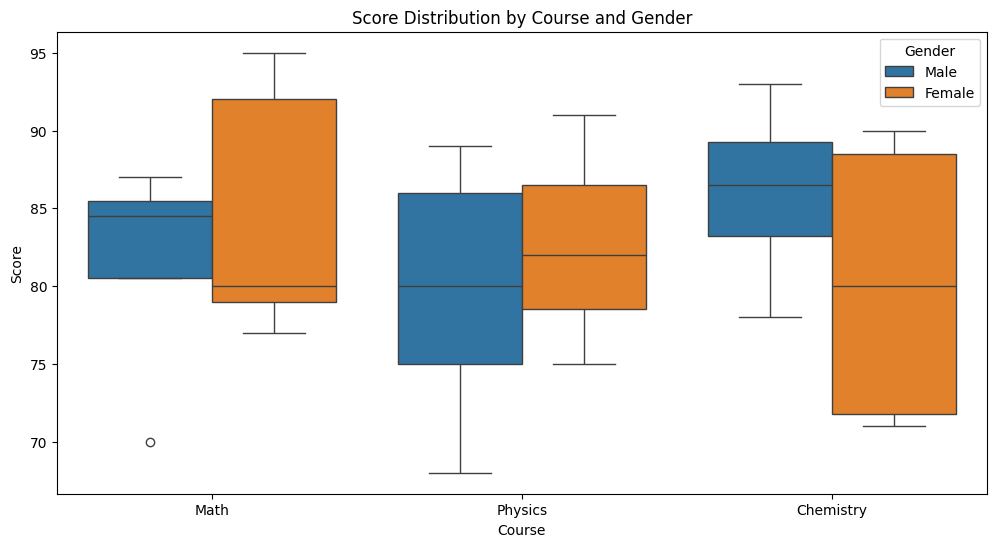

In [23]:
# 5. (4 điểm) Vẽ boxplot của Score theo Course và Gender (kết hợp) bằng Seaborn. Xác định outlier
# bằng IQR, sau đó đề xuất một kế hoạch hỗ trợ cá nhân cho các sinh viên outlier để cải thiện kết
# quả học tập, giải thích cách kế hoạch này nâng cao chất lượng giáo dục
plt.figure(figsize=(12, 6))
sns.boxplot(x='Course', y='Score', hue='Gender', data=df)
plt.title('Score Distribution by Course and Gender')
plt.savefig('score_boxplot.png')

# Identify outliers using IQR method
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

score_outliers = find_outliers_iqr(df, 'Score')
print("\nOutliers in Score column:")
print(score_outliers[['Student_ID', 'Course', 'Score']])

In [44]:
# 6. (4 điểm) Tạo cột mới Efficiency = Score / Study_Hours. Tìm sinh viên có Efficiency cao nhất,
# sau đó đề xuất một phần thưởng hoặc chương trình học bổng dựa trên chỉ số này, giải thích tác
# động của nó đến động lực học tập của sinh viên khác.


# Tạo DataFrame đã được điền giá trị thiếu
df_filled = df.copy()

# Điền giá trị thiếu cho Score bằng trung bình theo Course
df_filled['Score'] = df_filled['Score'].fillna(df_filled.groupby('Course')['Score'].transform('mean'))

# Điền giá trị thiếu cho Study_Hours bằng median
df_filled['Study_Hours'] = df_filled['Study_Hours'].fillna(df_filled['Study_Hours'].median())

# Tính Efficiency
df_filled['Efficiency'] = df_filled['Score'] / df_filled['Study_Hours']

# Tìm sinh viên có Efficiency cao nhất
most_efficient_student = df_filled.loc[df_filled['Efficiency'].idxmax()]

print("\nMost efficient student:")
print(most_efficient_student[['Student_ID', 'Course', 'Score', 'Study_Hours', 'Efficiency']])


Most efficient student:
Student_ID          S021
Course         Chemistry
Score               66.0
Study_Hours          2.0
Efficiency          33.0
Name: 20, dtype: object


In [46]:
# 7. (4 điểm) Tính tỷ lệ sinh viên nữ (Gender = Female) trong từng Course sau khi điền giá trị thiếu
# bằng mode. Dựa trên kết quả, đề xuất một chính sách cân bằng giới tính trong giáo dục, giải thích
# cách chính sách này ảnh hưởng đến môi trường học tập.
df_gender_imputed = df.copy()
gender_mode = df['Gender'].mode()[0]
df_gender_imputed['Gender'] = df_gender_imputed['Gender'].fillna(gender_mode)

female_ratio_by_course = df_gender_imputed[df_gender_imputed['Gender'] == 'Female'].groupby('Course').size() / df_gender_imputed.groupby('Course').size()
print("\nFemale student ratio by course:")
print(female_ratio_by_course)



Female student ratio by course:
Course
Chemistry    0.6
Math         0.6
Physics      0.5
dtype: float64


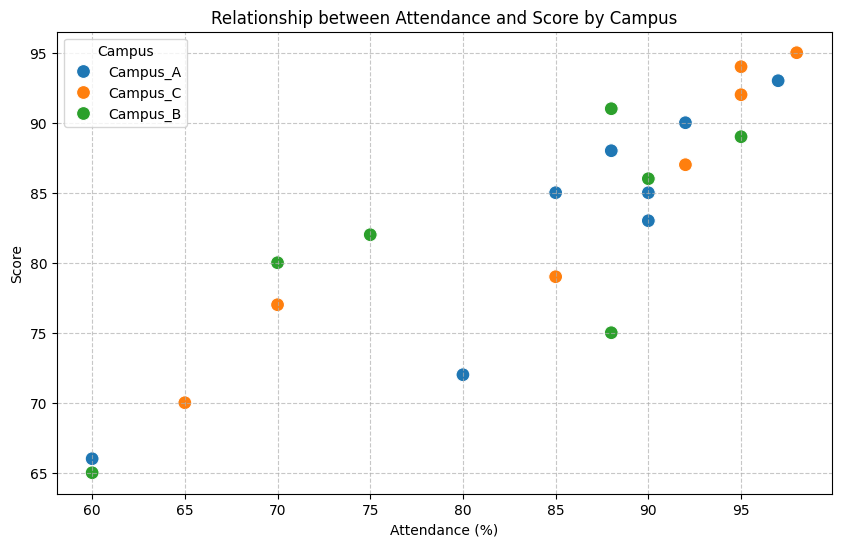

Correlation between Attendance and Score for Campus_A: 0.92
Correlation between Attendance and Score for Campus_C: 0.95
Correlation between Attendance and Score for Campus_B: 0.77


In [47]:
# 8. (4 điểm) Vẽ scatter plot giữa Attendance (%) và Score, tô màu theo Campus. Đề xuất một kế
# hoạch cải thiện điểm danh cho từng Campus dựa trên phân bố dữ liệu, giải thích tại sao kế hoạch
# này tối ưu hóa kết quả học tập.
# Create a copy of the dataframe
df_attendance = df.copy()

# Drop rows with missing values in Attendance or Score
df_attendance_clean = df_attendance.dropna(subset=['Attendance (%)', 'Score'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Attendance (%)', y='Score', hue='Campus', data=df_attendance_clean, s=100)
plt.title('Relationship between Attendance and Score by Campus')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Calculate correlation for each campus
for campus in df_attendance_clean['Campus'].unique():
    campus_data = df_attendance_clean[df_attendance_clean['Campus'] == campus]
    correlation = campus_data[['Attendance (%)', 'Score']].corr().iloc[0, 1]
    print(f"Correlation between Attendance and Score for {campus}: {correlation:.2f}")


Average score by course after imputation:
Course
Physics      79.0
Chemistry    81.4
Math         84.3
Name: Score, dtype: float64


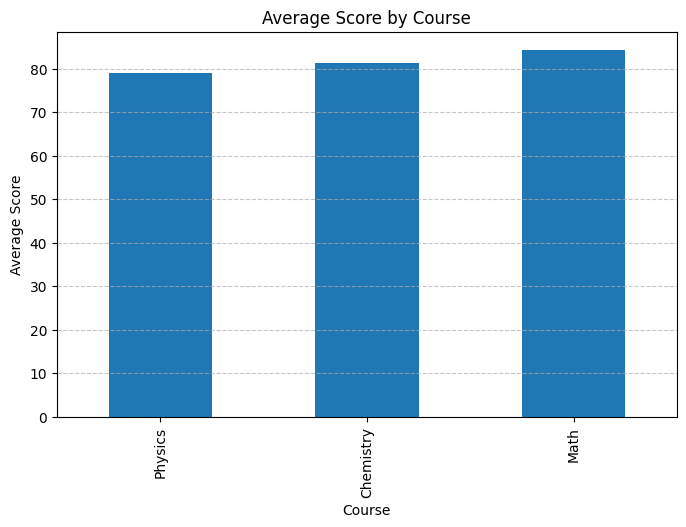

In [48]:
# 9. (4 điểm) Tính trung bình Score của từng Course sau khi điền dữ liệu thiếu. Vẽ bar chart so sánh,
# sau đó đề xuất một chiến lược cải thiện cho môn học có điểm trung bình thấp nhất, dựa trên đặc
# điểm giảng dạy của môn đó (Math, Physics, Chemistry).
# Tạo DataFrame với dữ liệu Score đã được điền giá trị thiếu
df_filled = df.copy()
df_filled['Score'] = df_filled['Score'].fillna(df_filled.groupby('Course')['Score'].transform('mean'))

# Tính điểm trung bình theo Course và sắp xếp
course_avg_scores = df_filled.groupby('Course')['Score'].mean().sort_values()
print("\nAverage score by course after imputation:")
print(course_avg_scores)

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
course_avg_scores.plot(kind='bar')
plt.title('Average Score by Course')
plt.xlabel('Course')
plt.ylabel('Average Score')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('avg_score_by_course.png')

In [49]:
# 10. (4 điểm) Tìm các sinh viên có Attendance (%) dưới 70% nhưng Score trên 85 bằng Pandas. Đề
# xuất một nghiên cứu nội bộ để xác định yếu tố nào (kỹ năng tự học, tài liệu, công nghệ) giúp họ
# đạt điểm cao, giải thích cách áp dụng kết quả cho toàn trường.
# Create a copy of the dataframe
df_high_performers = df.copy()

# Drop rows with missing values in relevant columns
df_high_performers_clean = df_high_performers.dropna(subset=['Attendance (%)', 'Score'])

# Find students with Attendance < 70% but Score > 85
high_performers = df_high_performers_clean[(df_high_performers_clean['Attendance (%)'] < 70) & 
                                        (df_high_performers_clean['Score'] > 85)]

print("Sinh viên có Attendance dưới 70% nhưng Score trên 85:")
print(high_performers[['Student_ID', 'Course', 'Attendance (%)', 'Score', 'Study_Hours']])

# Analyze characteristics of these students
if not high_performers.empty:
    avg_study_hours = high_performers['Study_Hours'].mean()
    print(f"\nSố giờ học trung bình của nhóm này: {avg_study_hours:.2f}")
    
    courses_distribution = high_performers['Course'].value_counts()
    print("\nPhân bố theo môn học:")
    print(courses_distribution)

Sinh viên có Attendance dưới 70% nhưng Score trên 85:
Empty DataFrame
Columns: [Student_ID, Course, Attendance (%), Score, Study_Hours]
Index: []


Mô hình hồi quy tuyến tính thủ công:
Score = 40.0277 + 0.3225 * Attendance (%) + 3.3388 * Study_Hours


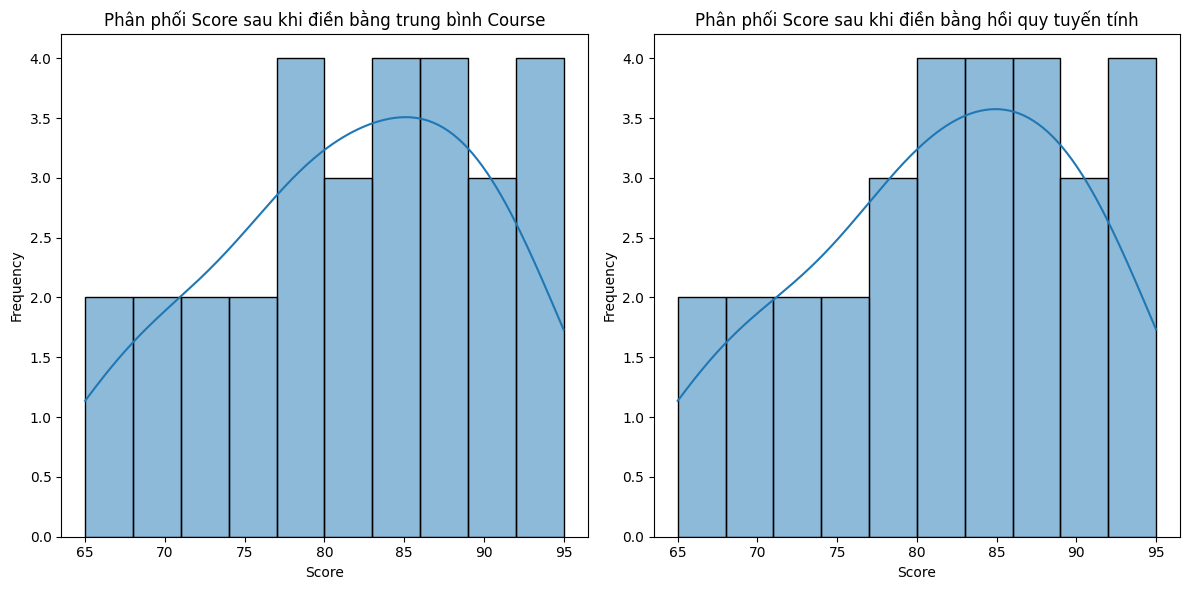


Thống kê sau khi điền bằng phương pháp trung bình:
count    30.000000
mean     81.566667
std       8.568923
min      65.000000
25%      75.500000
50%      82.500000
75%      88.000000
max      95.000000
Name: Score, dtype: float64

Thống kê sau khi điền bằng phương pháp hồi quy:
count    30.000000
mean     81.626416
std       8.556649
min      65.000000
25%      75.500000
50%      82.500000
75%      88.000000
max      95.000000
Name: Score, dtype: float64


In [51]:
# Câu 11: Điền giá trị thiếu trong Score bằng hồi quy tuyến tính thủ công dựa trên Attendance (%) và Study_Hours

df_regression = df.copy()

# Tạo dữ liệu huấn luyện (loại bỏ các dòng có giá trị NaN trong các biến dự đoán)
train_data = df_regression.dropna(subset=['Score', 'Attendance (%)', 'Study_Hours'])

# Xây dựng mô hình hồi quy thủ công
X = train_data[['Attendance (%)', 'Study_Hours']].values
y = train_data['Score'].values

# Thêm cột hằng số 1 vào ma trận X để tính intercept
X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))

# Tính các hệ số bằng công thức hồi quy tuyến tính: beta = (X^T X)^(-1) X^T y
beta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y

# Tách intercept và các hệ số
alpha = beta[0]
beta1 = beta[1]  # hệ số cho Attendance
beta2 = beta[2]  # hệ số cho Study_Hours

print("Mô hình hồi quy tuyến tính thủ công:")
print(f"Score = {alpha:.4f} + {beta1:.4f} * Attendance (%) + {beta2:.4f} * Study_Hours")

# Điền giá trị thiếu bằng mô hình hồi quy
df_regression_imputed = df_regression.copy()
for idx, row in df_regression_imputed.iterrows():
    if pd.isna(row['Score']) and not pd.isna(row['Attendance (%)']) and not pd.isna(row['Study_Hours']):
        predicted_score = alpha + beta1 * row['Attendance (%)'] + beta2 * row['Study_Hours']
        df_regression_imputed.at[idx, 'Score'] = predicted_score

# Điền giá trị thiếu bằng phương pháp trung bình của Course
df_mean_imputed = df.copy()
course_means = df_mean_imputed.groupby('Course')['Score'].mean()
for course in df_mean_imputed['Course'].unique():
    mean_score = course_means[course]
    df_mean_imputed.loc[(df_mean_imputed['Course'] == course) & (df_mean_imputed['Score'].isnull()), 'Score'] = mean_score

# So sánh kết quả của hai phương pháp
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_mean_imputed['Score'], kde=True, bins=10)
plt.title('Phân phối Score sau khi điền bằng trung bình Course')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_regression_imputed['Score'], kde=True, bins=10)
plt.title('Phân phối Score sau khi điền bằng hồi quy tuyến tính')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Phân tích thống kê mô tả sau khi điền
print("\nThống kê sau khi điền bằng phương pháp trung bình:")
print(df_mean_imputed['Score'].describe())
print("\nThống kê sau khi điền bằng phương pháp hồi quy:")
print(df_regression_imputed['Score'].describe())

Độ lệch (skewness) của Score: -0.3309


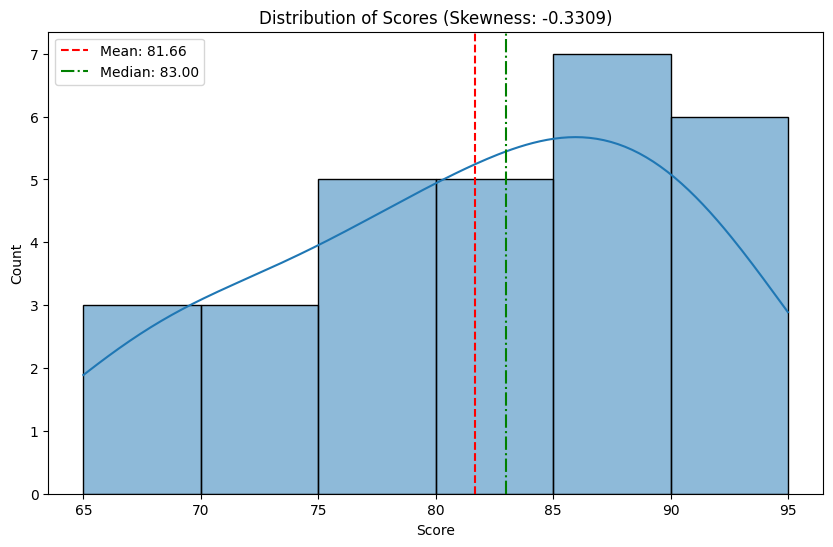

In [52]:
# 12. (4 điểm) Tính skewness của Score bằng SciPy. Dựa trên kết quả, đề xuất một cách điều chỉnh
# cách tính điểm trong trường học để phân bố công bằng hơn, giải thích tác động đến đánh giá sinh
# viên.
from scipy import stats

# Calculate skewness for Score
score_skew = stats.skew(df['Score'].dropna())
print(f"Độ lệch (skewness) của Score: {score_skew:.4f}")

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Score'].dropna(), kde=True)
plt.axvline(df['Score'].dropna().mean(), color='r', linestyle='--', label=f'Mean: {df["Score"].dropna().mean():.2f}')
plt.axvline(df['Score'].dropna().median(), color='g', linestyle='-.', label=f'Median: {df["Score"].dropna().median():.2f}')
plt.title(f'Distribution of Scores (Skewness: {score_skew:.4f})')
plt.legend()
plt.show()

C:\Users\amii9\AppData\Local\Temp\ipykernel_7744\4055674274.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pairplot['Attendance (%)'].fillna(df_pairplot['Attendance (%)'].mean(), inplace=True)
C:\Users\amii9\AppData\Local\Temp\ipykernel_7744\4055674274.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

<Figure size 1200x1000 with 0 Axes>

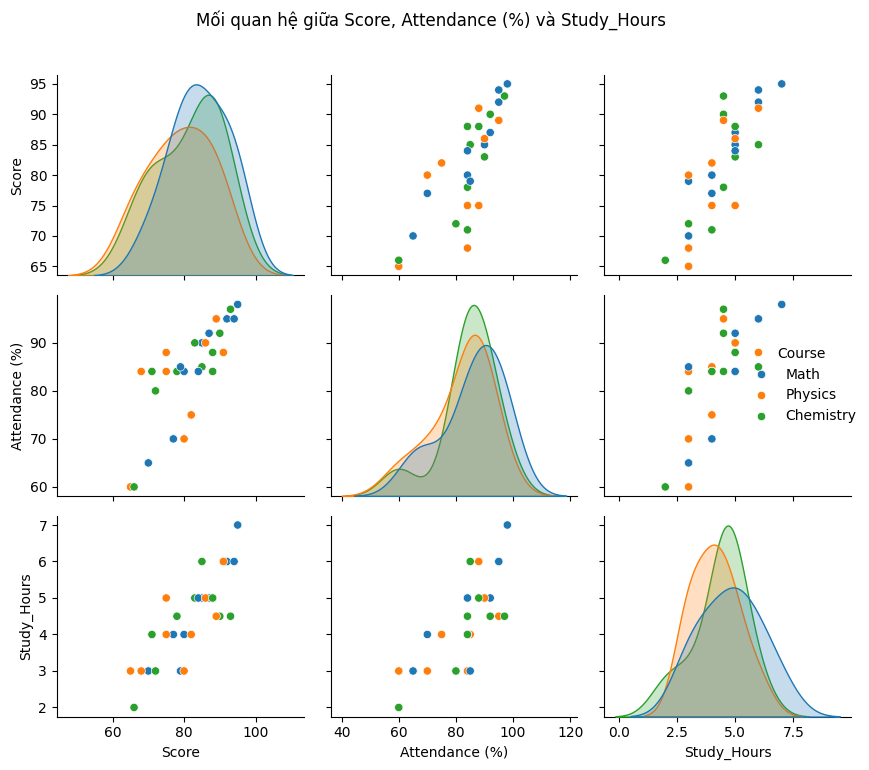

Ma trận tương quan:
                   Score  Attendance (%)  Study_Hours
Score           1.000000        0.784461     0.816746
Attendance (%)  0.784461        1.000000     0.745103
Study_Hours     0.816746        0.745103     1.000000


In [53]:
# 13. (4 điểm) Vẽ pairplot bằng Seaborn cho Score, Attendance (%), Study_Hours. Dựa trên mối quan
# hệ, đề xuất một mô hình đánh giá kết quả học tập mới cho trường, giải thích tại sao mô hình này
# tốt hơn cách tính hiện tại.
df_pairplot = df.copy()
df_pairplot['Attendance (%)'].fillna(df_pairplot['Attendance (%)'].mean(), inplace=True)
df_pairplot['Study_Hours'].fillna(df_pairplot['Study_Hours'].median(), inplace=True)

# Vẽ pairplot
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(df_pairplot[['Score', 'Attendance (%)', 'Study_Hours', 'Course']], hue='Course')
plt.suptitle('Mối quan hệ giữa Score, Attendance (%) và Study_Hours', y=1.02)
plt.tight_layout()
plt.show()

# Tính ma trận tương quan
correlation_matrix = df_pairplot[['Score', 'Attendance (%)', 'Study_Hours']].corr()
print("Ma trận tương quan:")
print(correlation_matrix)


Ratio of students with Score > 80 by Campus:
Campus_A: 63.64%
Campus_B: 40.00%
Campus_C: 55.56%


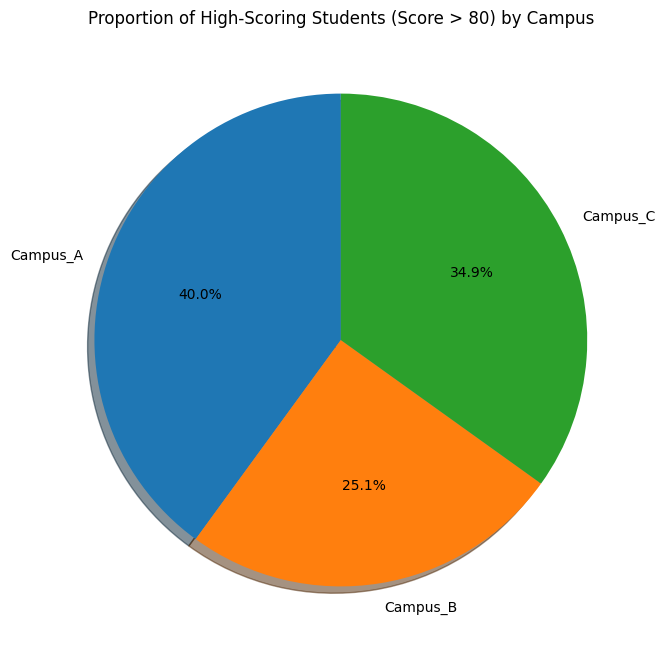

In [36]:
# 14. (4 điểm) Nhóm dữ liệu theo Campus, tính tỷ lệ sinh viên có Score trên 80. Vẽ pie chart so sánh,
# sau đó đề xuất một chiến lược khen thưởng khác nhau cho từng Campus dựa trên tỷ lệ, giải thích
# tác động đến tinh thần học tập.

campus_high_score_ratio = {}
for campus, group in df_mean_imputed.groupby('Campus'):
    total_students = len(group)
    high_score_students = len(group[group['Score'] > 80])
    campus_high_score_ratio[campus] = high_score_students / total_students

print("\nRatio of students with Score > 80 by Campus:")
for campus, ratio in campus_high_score_ratio.items():
    print(f"{campus}: {ratio:.2%}")

plt.figure(figsize=(8, 8))
plt.pie(list(campus_high_score_ratio.values()), labels=list(campus_high_score_ratio.keys()), 
        autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Proportion of High-Scoring Students (Score > 80) by Campus')
plt.savefig('high_score_pie_chart.png')

In [54]:
#15. (4 điểm) Tạo hàm Python xác định sinh viên có Score ngoài 2 độ lệch chuẩn. Đề xuất một quy
# trình đánh giá lại điểm số cho những sinh viên này, giải thích cách quy trình này tránh được thiên
# vị trong giáo dục
def identify_outlier_students(df, score_col='Score', std_threshold=2):
    """Identify students with scores outside the specified standard deviation threshold"""
    mean_score = df[score_col].mean()
    std_score = df[score_col].std()
    lower_bound = mean_score - std_threshold * std_score
    upper_bound = mean_score + std_threshold * std_score
    
    outliers = df[(df[score_col] < lower_bound) | (df[score_col] > upper_bound)]
    return outliers

score_outliers_std = identify_outlier_students(df_mean_imputed)
print("\nStudents with scores outside 2 standard deviations:")
print(score_outliers_std[['Student_ID', 'Course', 'Score']])


Students with scores outside 2 standard deviations:
Empty DataFrame
Columns: [Student_ID, Course, Score]
Index: []


## Câu hỏi ANN (40 điểm)
### Xây dựng một ANN để dự đoán Score dựa trên Attendance (%), Study_Hours, và Course (mã hóaone-hot encoding).

Columns in DataFrame: ['Student_ID', 'Course', 'Score', 'Attendance (%)', 'Study_Hours', 'Gender', 'Campus']

Missing values count before imputation:
Attendance (%)    7
Study_Hours       4
dtype: int64

So sánh giá trị sau khi điền:

Thống kê Attendance (%) - Median Imputation:
count    30.000000
mean     84.966667
std      10.340691
min      60.000000
25%      85.000000
50%      88.000000
75%      90.000000
max      98.000000
Name: Attendance (%), dtype: float64

Thống kê Attendance (%) - KNN Imputation:
count    30.000000
mean     83.188889
std      10.876416
min      60.000000
25%      75.416667
50%      86.500000
75%      91.250000
max      98.000000
Name: Attendance (%), dtype: float64

Thống kê Study_Hours - Median Imputation:
count    30.000000
mean      4.433333
std       1.150212
min       2.000000
25%       4.000000
50%       4.500000
75%       5.000000
max       7.000000
Name: Study_Hours, dtype: float64

Thống kê Study_Hours - KNN Imputation:
count    30.000000
mean      4

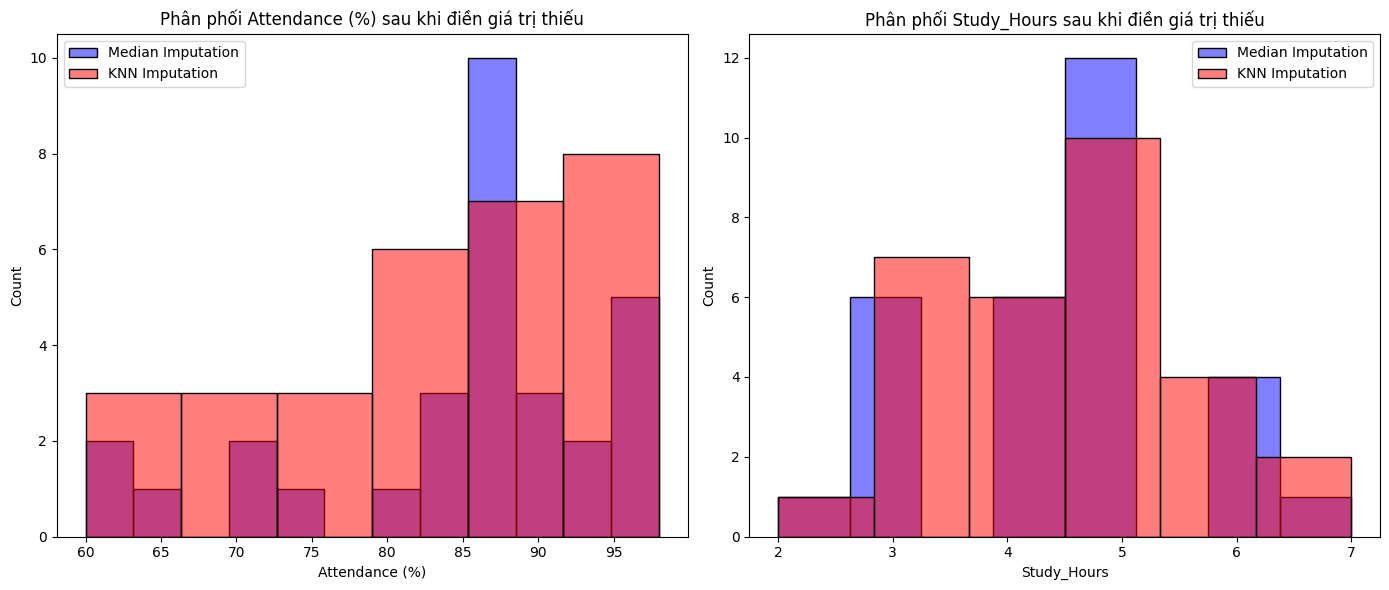


Độ lệch chuẩn của dữ liệu sau khi điền:
Attendance (%) - Median: 10.340690743730386
Attendance (%) - KNN: 10.876415954266236
Study_Hours - Median: 1.150212374193186
Study_Hours - KNN: 1.2307781338709325


In [56]:
# 16. (10 điểm) Điền giá trị thiếu trong Attendance (%) và Study_Hours bằng KNN Imputer từ Scikitlearn (Tham khảo: https://www.geeksforgeeks.org/handling-missing-data-with-knn-imputer/). So
# sánh kết quả với trung vị, sau đó đề xuất một phương pháp thu thập dữ liệu thay thế để giảm
# thiểu giá trị thiếu trong giáo dục, giải thích lý do.
# First, check the actual column names in your dataframe
# 16. (10 điểm) Điền giá trị thiếu trong Attendance (%) và Study_Hours bằng KNN Imputer

# Import thư viện cần thiết
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Kiểm tra tên cột và số lượng giá trị thiếu
print("Columns in DataFrame:", df.columns.tolist())
print("\nMissing values count before imputation:")
print(df[['Attendance (%)', 'Study_Hours']].isnull().sum())

# Tạo bản sao để so sánh các phương pháp
df_median_imputed = df.copy()
df_knn_imputed = df.copy()

# Phương pháp 1: Điền giá trị bằng median
df_median_imputed['Attendance (%)'] = df_median_imputed['Attendance (%)'].fillna(df_median_imputed['Attendance (%)'].median())
df_median_imputed['Study_Hours'] = df_median_imputed['Study_Hours'].fillna(df_median_imputed['Study_Hours'].median())

# Phương pháp 2: Điền giá trị bằng KNN Imputer
# Chuẩn bị dữ liệu số cho KNN Imputer
num_cols = ['Score', 'Attendance (%)', 'Study_Hours']
# Tạo một bản sao của các cột số này để tránh cảnh báo về việc thay đổi dữ liệu gốc
df_numeric = df[num_cols].copy()

# Áp dụng KNN Imputer
knn_imputer = KNNImputer(n_neighbors=3)
imputed_data = knn_imputer.fit_transform(df_numeric)

# Cập nhật dữ liệu đã được điền vào DataFrame
df_knn_imputed[num_cols] = imputed_data

# So sánh kết quả
print("\nSo sánh giá trị sau khi điền:")
print("\nThống kê Attendance (%) - Median Imputation:")
print(df_median_imputed['Attendance (%)'].describe())
print("\nThống kê Attendance (%) - KNN Imputation:")
print(df_knn_imputed['Attendance (%)'].describe())

print("\nThống kê Study_Hours - Median Imputation:")
print(df_median_imputed['Study_Hours'].describe())
print("\nThống kê Study_Hours - KNN Imputation:")
print(df_knn_imputed['Study_Hours'].describe())

# Trực quan hóa so sánh giữa hai phương pháp
plt.figure(figsize=(14, 6))

# So sánh phân phối Attendance (%)
plt.subplot(1, 2, 1)
sns.histplot(df_median_imputed['Attendance (%)'], color='blue', alpha=0.5, label='Median Imputation')
sns.histplot(df_knn_imputed['Attendance (%)'], color='red', alpha=0.5, label='KNN Imputation')
plt.title('Phân phối Attendance (%) sau khi điền giá trị thiếu')
plt.legend()

# So sánh phân phối Study_Hours
plt.subplot(1, 2, 2)
sns.histplot(df_median_imputed['Study_Hours'], color='blue', alpha=0.5, label='Median Imputation')
sns.histplot(df_knn_imputed['Study_Hours'], color='red', alpha=0.5, label='KNN Imputation')
plt.title('Phân phối Study_Hours sau khi điền giá trị thiếu')
plt.legend()

plt.tight_layout()
plt.show()

# Kiểm tra biến thiên của dữ liệu sau khi điền
print("\nĐộ lệch chuẩn của dữ liệu sau khi điền:")
print("Attendance (%) - Median:", df_median_imputed['Attendance (%)'].std())
print("Attendance (%) - KNN:", df_knn_imputed['Attendance (%)'].std())
print("Study_Hours - Median:", df_median_imputed['Study_Hours'].std())
print("Study_Hours - KNN:", df_knn_imputed['Study_Hours'].std())

In [58]:
# 17. (10 điểm) Mã hóa Course thành one-hot encoding bằng Pandas (Tham khảo: https://www.geeksforgeeks.org/mlone-hot-encoding/). Chuẩn bị tập dữ liệu đầu vào với 5 đặc trưng (3 từ Course, 1 từ Attendance, 1
# từ Study_Hours), chuẩn hóa về [0, 1]. Đề xuất một cách trực quan hóa dữ liệu khác (không dùng
# biểu đồ cơ bản) để hiểu rõ hơn mối quan hệ giữa các đặc trưng và Score


# Tạo bản sao của dataframe gốc
df_encoded = df.copy()

# Điền giá trị thiếu trước khi mã hóa
df_encoded['Attendance (%)'] = df_encoded['Attendance (%)'].fillna(df_encoded['Attendance (%)'].mean())
df_encoded['Study_Hours'] = df_encoded['Study_Hours'].fillna(df_encoded['Study_Hours'].median())
df_encoded['Score'] = df_encoded['Score'].fillna(df_encoded.groupby('Course')['Score'].transform('mean'))

# Mã hóa Course thành one-hot encoding
course_dummies = pd.get_dummies(df_encoded['Course'], prefix='Course')
df_encoded = pd.concat([df_encoded, course_dummies], axis=1)

# Tạo các đặc trưng đầu vào (X) và biến mục tiêu (y)
X_features = df_encoded[['Attendance (%)', 'Study_Hours', 'Course_Math', 'Course_Physics', 'Course_Chemistry']]
y_target = df_encoded['Score']

# Chuẩn hóa các đặc trưng về [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_features)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)

print("\nDữ liệu sau khi mã hóa one-hot và chuẩn hóa:")
print(X_scaled_df.head())

# Thêm Score đã chuẩn hóa vào DataFrame để phân tích
X_scaled_df['Score_scaled'] = scaler.fit_transform(y_target.values.reshape(-1, 1))

print("\nDữ liệu bao gồm cả Score đã chuẩn hóa:")
print(X_scaled_df.head())


Dữ liệu sau khi mã hóa one-hot và chuẩn hóa:
   Attendance (%)  Study_Hours  Course_Math  Course_Physics  Course_Chemistry
0        0.789474          0.6          1.0             0.0               0.0
1        0.657895          0.4          0.0             1.0               0.0
2        0.632723          0.5          0.0             0.0               1.0
3        0.921053          0.8          1.0             0.0               0.0
4        0.000000          0.2          0.0             1.0               0.0

Dữ liệu bao gồm cả Score đã chuẩn hóa:
   Attendance (%)  Study_Hours  Course_Math  Course_Physics  Course_Chemistry  \
0        0.789474          0.6          1.0             0.0               0.0   
1        0.657895          0.4          0.0             1.0               0.0   
2        0.632723          0.5          0.0             0.0               1.0   
3        0.921053          0.8          1.0             0.0               0.0   
4        0.000000          0.2          0

ANN(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 10/200, Train Loss: 6689.5352, Val Loss: 6893.2446
Epoch 20/200, Train Loss: 6628.5625, Val Loss: 6879.4258
Epoch 30/200, Train Loss: 6552.8533, Val Loss: 6862.2642
Epoch 40/200, Train Loss: 6565.1995, Val Loss: 6833.1265
Epoch 50/200, Train Loss: 6653.9812, Val Loss: 6776.6074
Epoch 60/200, Train Loss: 6358.9021, Val Loss: 6668.0098
Epoch 70/200, Train Loss: 6225.8779, Val Loss: 6468.8286
Epoch 80/200, Train Loss: 5849.9268, Val Loss: 6126.1724
Epoch 90/200, Train Loss: 5389.0830, Val Loss: 5582.6909
Epoch 100/200, Train Loss: 4879.8877, Val Loss: 4798.3486
Epoch 110/200, Train Loss: 3754.1870, Val Loss: 3787.2332
Epoch 120/200, Train Loss: 2609.7452, Val Loss: 2645.3628
Epoch 130/200, T

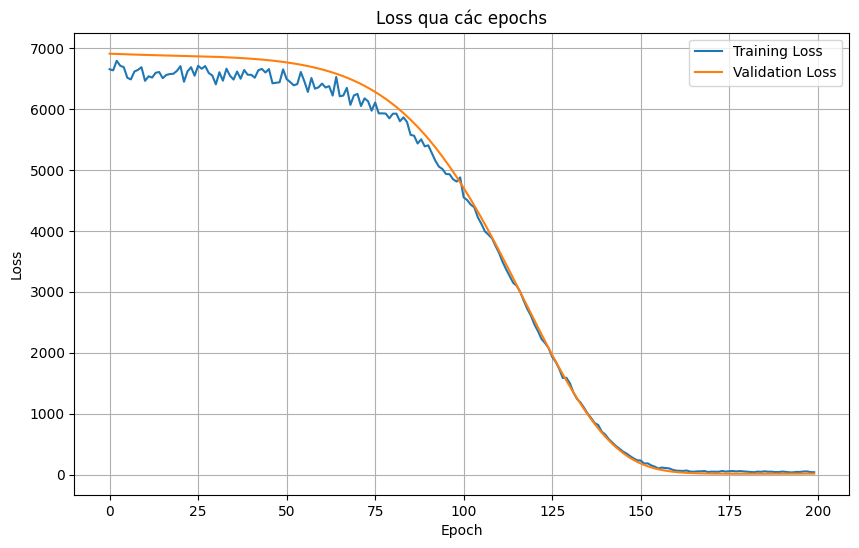

Mean Squared Error: 14.8178
R² Score: 0.8507


In [60]:
# 18. (15 điểm) Xây dựng ANN bằng PyTorch với kiến trúc như hình sau:
# • Input Layer: 5 nơ-ron.
# • Hidden Layer 1: 32 nơ-ron, ReLU.
# • Hidden Layer 2: 16 nơ-ron, ReLU.
# • Hidden Layer 3: 8 nơ-ron, ReLU.
# • Output Layer: 1 nơ-ron (Score).
# Huấn luyện với 200 epochs, batch size 16, chia 80% train / 20% test, dùng early stopping (patience=20). Vẽ biểu đồ loss, sau đó đề xuất một kiến trúc ANN khác (thay đổi số nơ-ron hoặc
# tầng) để cải thiện dự đoán, giải thích lý do dựa trên đặc điểm dữ liệu giáo dục.
# 18. (15 điểm) Xây dựng ANN bằng PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Chuẩn bị dữ liệu
df_ann = df_encoded.copy()

# Định nghĩa các đặc trưng cần dùng
features = ['Attendance (%)', 'Study_Hours', 'Course_Math', 'Course_Physics', 'Course_Chemistry']

# Chọn các đặc trưng và target
X = df_ann[features].values
y = df_ann['Score'].values

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Chuyển đổi thành tensor
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))

# Định nghĩa mô hình ANN
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(5, 32)  # Input layer (5) to Hidden layer 1 (32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)  # Hidden layer 1 (32) to Hidden layer 2 (16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 8)   # Hidden layer 2 (16) to Hidden layer 3 (8)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(8, 1)    # Hidden layer 3 (8) to Output layer (1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Khởi tạo mô hình
model = ANN()
print(model)

# Định nghĩa loss function và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tạo DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Huấn luyện mô hình với early stopping
epochs = 200
patience = 20
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss qua các epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Đánh giá mô hình
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()
    
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')





Model Evaluation:
Mean Squared Error: 14.8178
R² Score: 0.8507


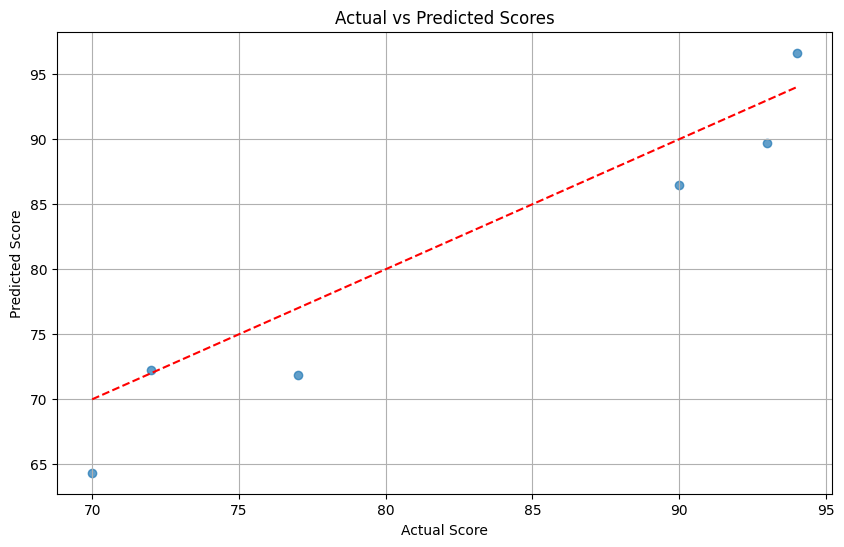

In [62]:
# 19. (5 điểm) Đánh giá mô hình bằng MSE và R² trên tập test. Nếu R² dưới 0.8, phân tích nguyên
# nhân sai lệch dự đoán dựa trên đặc trưng đầu vào, đề xuất một cách cải thiện mô hình dựa trên
# ngữ cảnh giáo dục (không chỉ dùng dropout hay thay đổi optimizer)
# Đánh giá mô hình trên tập test
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    
    # Calculate MSE and R²
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nModel Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # If R² is below 0.8, analyze the reasons
    if r2 < 0.8:
        print("R² is below 0.8. Analyzing potential reasons for prediction errors...")
        
        # Calculate feature importance based on weights (simplified approach)
        feature_importance = {}
        with torch.no_grad():
            weights = model.layer1.weight.abs().mean(dim=0).numpy()
            for i, feature in enumerate(X_features.columns):
                feature_importance[feature] = weights[i]
        
        print("\nFeature importance (based on first layer weights):")
        for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature}: {importance:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores')
plt.grid(True)
plt.savefig('actual_vs_predicted.png')